In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings

warnings.filterwarnings('ignore')

# 设置数据路径
data_path = "data"

# 1️⃣ 加载数据
df1 = pd.read_csv(f"{data_path}/car_data.csv")
df2 = pd.read_csv(f"{data_path}/CAR_DETAILS_FROM_CAR_DEKHO.csv")
df3 = pd.read_csv(f"{data_path}/Car_details_v3.csv")

# 2️⃣ 标准化字段名
df1.rename(columns={
    "Car_Name": "name", "Year": "year", "Selling_Price": "selling_price",
    "Present_Price": "present_price", "Kms_Driven": "km_driven",
    "Fuel_Type": "fuel", "Seller_Type": "seller_type",
    "Transmission": "transmission", "Owner": "owner"
}, inplace=True)

# 3️⃣ 合并数据集并统一列名为小写
df_combined = pd.concat([df1, df2, df3], ignore_index=True)
df_combined.columns = df_combined.columns.str.lower()

print("✅ 合并后数据集维度:", df_combined.shape)
print("📌 字段数据类型：\n", df_combined.dtypes)


✅ 合并后数据集维度: (11875, 14)
📌 字段数据类型：
 name              object
year               int64
selling_price    float64
present_price    float64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object


In [16]:
# 1️⃣ 缺失值统计
print("\n📌 缺失值统计：\n", df_combined.isnull().sum())

# 2️⃣ 描述性统计
print("\n📌 原始数据描述统计：\n", df_combined.describe())

# 3️⃣ 删除 present_price 列
if "present_price" in df_combined.columns:
    df_combined["present_price"] = pd.to_numeric(df_combined["present_price"], errors="coerce")
    df_combined.drop(columns=["present_price"], inplace=True)

# 4️⃣ name 列进行 target encoding
df_combined["name_target_enc"] = df_combined.groupby("name")["selling_price"].transform("mean")
df_combined.drop(columns=["name"], inplace=True)

# 5️⃣ owner 类型映射
owner_mapping = {
    "First Owner": 1, "Second Owner": 2, "Third Owner": 3,
    "Fourth & Above Owner": 4, "Test Drive Car": 0
}
df_combined["owner"] = df_combined["owner"].map(owner_mapping).fillna(0).astype(int)

# 6️⃣ 数值字段提取 + 缺失值填充
for col in ["selling_price", "km_driven", "mileage", "engine", "max_power", "seats", "torque"]:
    if col in df_combined.columns:
        df_combined[col] = df_combined[col].astype(str).str.extract(r"(\d+\.\d+|\d+)").astype(float)
        df_combined[col].fillna(df_combined[col].median(), inplace=True)

# 7️⃣ One-Hot 编码（类别型字段）
df_combined = pd.get_dummies(df_combined, columns=["fuel", "seller_type", "transmission"], drop_first=True)

print("📌 清洗后数据维度：", df_combined.shape)



📌 缺失值统计：
 name                 0
year                 0
selling_price        0
present_price    11595
km_driven            0
fuel                 0
seller_type          0
transmission         0
owner                0
mileage           4515
engine            4515
max_power         4512
torque            4516
seats             4515
dtype: int64

📌 原始数据描述统计：
                year  selling_price  present_price     km_driven        seats
count  11875.000000   1.187500e+04     280.000000  1.187500e+04  7360.000000
mean    2013.558232   5.755610e+05       7.470929  6.779149e+04     5.416576
std        4.101566   7.258874e+05       7.296562  5.351635e+04     0.955653
min     1983.000000   1.000000e-01       0.320000  1.000000e+00     2.000000
25%     2011.000000   2.250000e+05       1.050000  3.400000e+04     5.000000
50%     2014.000000   4.000000e+05       6.445000  6.000000e+04     5.000000
75%     2017.000000   6.500000e+05       9.910000  9.000000e+04     5.000000
max     2020.000000   1.

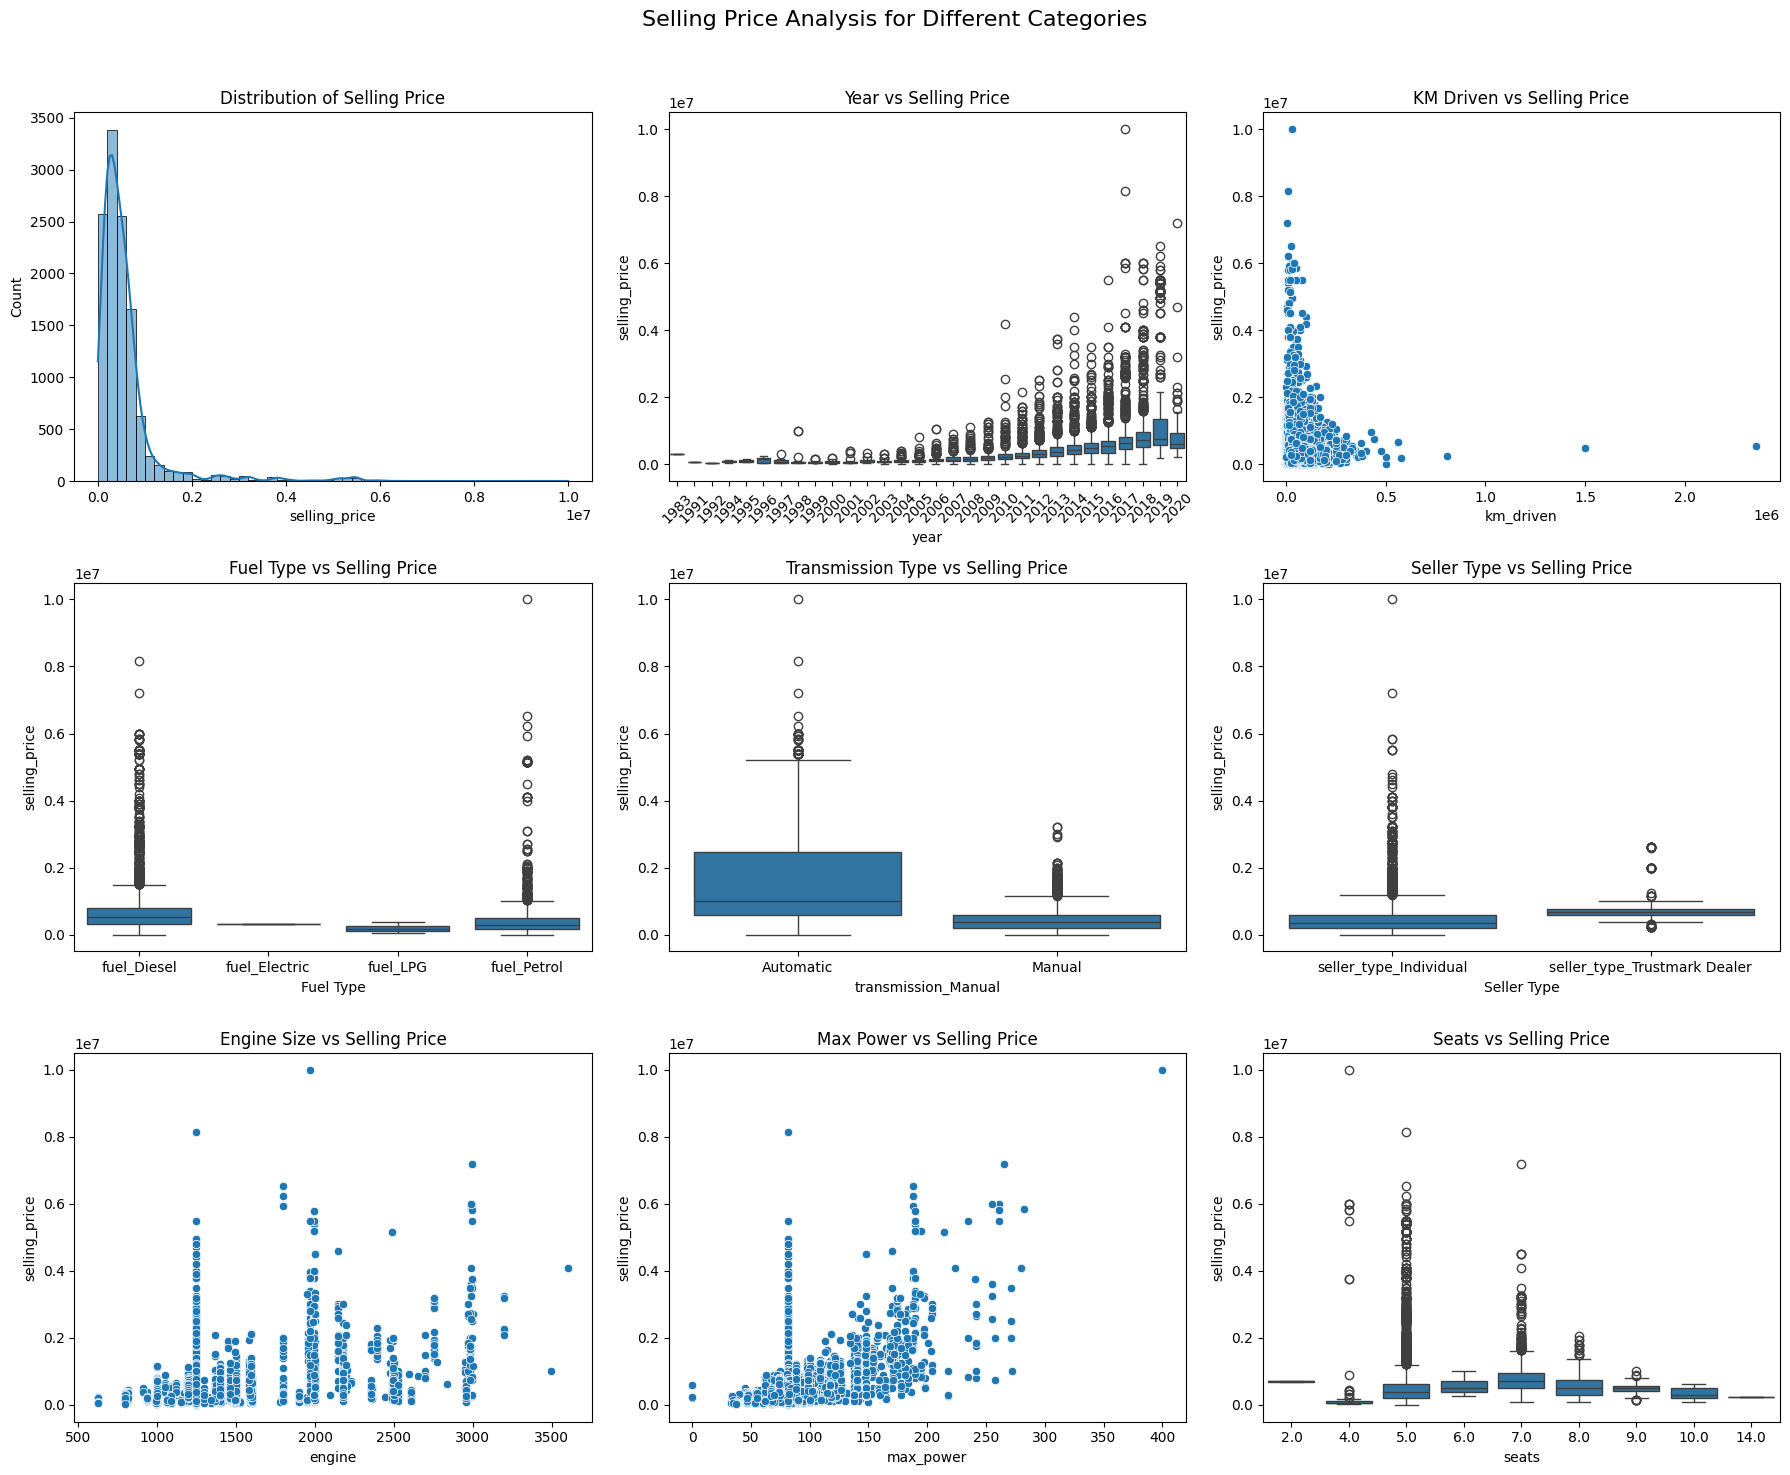

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle("Selling Price Analysis for Different Categories", fontsize=16)

sns.histplot(df_combined["selling_price"], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Selling Price")

sns.boxplot(x="year", y="selling_price", data=df_combined, ax=axes[0, 1])
axes[0, 1].set_title("Year vs Selling Price")
axes[0, 1].tick_params(axis='x', rotation=45)

sns.scatterplot(x="km_driven", y="selling_price", data=df_combined, ax=axes[0, 2])
axes[0, 2].set_title("KM Driven vs Selling Price")

fuel_cols = [col for col in df_combined.columns if col.startswith("fuel_")]
df_fuel = df_combined.melt(id_vars=["selling_price"], value_vars=fuel_cols, var_name="Fuel Type", value_name="Value")
df_fuel = df_fuel[df_fuel["Value"] == 1]
sns.boxplot(x="Fuel Type", y="selling_price", data=df_fuel, ax=axes[1, 0])
axes[1, 0].set_title("Fuel Type vs Selling Price")

sns.boxplot(x="transmission_Manual", y="selling_price", data=df_combined, ax=axes[1, 1])
axes[1, 1].set_title("Transmission Type vs Selling Price")
axes[1, 1].set_xticklabels(["Automatic", "Manual"])

seller_cols = [col for col in df_combined.columns if col.startswith("seller_type_")]
df_seller = df_combined.melt(id_vars=["selling_price"], value_vars=seller_cols, var_name="Seller Type", value_name="Value")
df_seller = df_seller[df_seller["Value"] == 1]
sns.boxplot(x="Seller Type", y="selling_price", data=df_seller, ax=axes[1, 2])
axes[1, 2].set_title("Seller Type vs Selling Price")

sns.scatterplot(x="engine", y="selling_price", data=df_combined, ax=axes[2, 0])
axes[2, 0].set_title("Engine Size vs Selling Price")

sns.scatterplot(x="max_power", y="selling_price", data=df_combined, ax=axes[2, 1])
axes[2, 1].set_title("Max Power vs Selling Price")

sns.boxplot(x="seats", y="selling_price", data=df_combined, ax=axes[2, 2])
axes[2, 2].set_title("Seats vs Selling Price")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


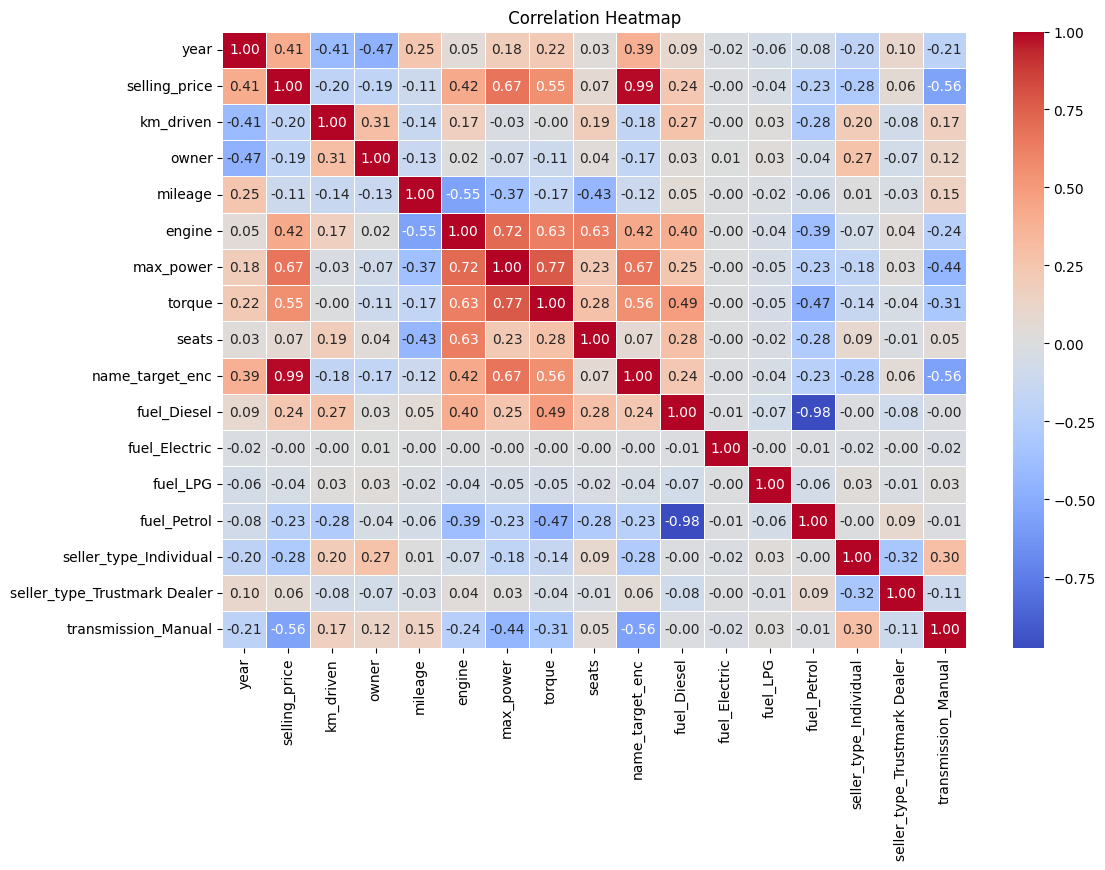

✅ 推荐用于建模的强相关特征：
- year
- engine
- max_power
- torque
- name_target_enc
- transmission_Manual


In [20]:
# 处理布尔字段
for col in df_combined.select_dtypes(include=["bool"]).columns:
    df_combined[col] = df_combined[col].astype(int)

# 数值型字段过滤
df_numeric = df_combined.select_dtypes(include=[np.number])
df_numeric = df_numeric.fillna(df_numeric.median())
df_numeric = df_numeric.loc[:, df_numeric.var() > 0]

# 热力图
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(" Correlation Heatmap ")
plt.show()

# 特征选择（与售价相关性 > 0.4）
correlation = df_numeric.corr()["selling_price"].abs()
selected_features = correlation[correlation > 0.4].index.tolist()
selected_features.remove("selling_price")

print("✅ 推荐用于建模的强相关特征：")
for feat in selected_features:
    print("-", feat)


In [22]:
df_combined.to_csv("data/processed_car_data.csv", index=False)
print("✅ 保存成功：data/processed_car_data.csv")


✅ 保存成功：data/processed_car_data.csv
